#### Import Necessary Libraries

In [1]:
import os 
import gcsfs
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#### Create Class for model training


In [2]:
class PetFinderClassifier:
    
    def __init__(self):
        """init constructor"""
        self.data = None
        self.features = None
        self.labels = None

        
    def load_data(self, path):
        """data loader method"""
        fs = gcsfs.GCSFileSystem(project='XGBoost_Classifier')

        with fs.open(path) as f:
            self.data = pd.read_csv(f)
            
            # Split Data into Training Features and Label
            self.features = self.data.iloc[:, :-1]
            self.labels = self.data.iloc[:, -1]
            
            # Convert training features from sting to category
            self.features = self.features.astype("category")

            # Encode Label column from string to integers
            label_encoder = LabelEncoder()
            label_encoder = label_encoder.fit(self.labels)
            self.labels = label_encoder.transform(self.labels)
        
        return self.data, self.features, self.labels
        
        
    def check_for_null(self):
        """check data for null values"""
        null_data = self.data.isna().sum()
        print("|-----------------------------------------|")
        print("There are {} numbers of null columns".format
                    (len(null_data) - self.data.shape[1]))
        print("|-----------------------------------------|")

     
    def split_data(self):
        """Split data into Train, Test & Val set (60-20-20)"""
        self.X_train, self.X_rem, self.y_train, self.y_rem = \
                train_test_split(self.features, self.labels, train_size=0.6)
        
        self.X_valid, self.X_test, self.y_valid, self.y_test = \
                train_test_split(self.X_rem, self.y_rem, test_size=0.5)
        print()
        print("|-----------------------------------------|")
        print('Shape of Train Data:', self.X_train.shape)  
        print('Shape of Train Label:', self.y_train.shape)
        print()

        print('Shape of Test Data:', self.X_test.shape)  
        print('Shape of Test Label:', self.y_test.shape)  
        print()

        print('Shape of Train Data:', self.X_valid.shape)  
        print('Shape of Train Data:', self.y_valid.shape)  
        print("|-----------------------------------------|")

        return self.X_train, self.y_train, self.X_valid, self.y_valid, self.X_test, self.y_test
        
           
     
    def train_model(self):
        """Train Model Using XGBoost Classifier"""
        eval_set = [(self.X_train, self.y_train), (self.X_valid, self.y_valid)]

        self.model = XGBClassifier(tree_method="gpu_hist", enable_categorical=True, use_label_encoder=False)
        
        self.model.fit(self.X_train, self.y_train, early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
        
        return self.model   
        
     
    
    def visualize(self, label):
        # retrieve model performance metrics
        results = self.model.evals_result()
        
        # Display Visualization of Model Performance
        plt.figure(figsize=(7,7))
        plt.plot(results["validation_0"][label], label="Training loss")
        plt.plot(results["validation_1"][label], label="Validation loss")
        plt.axvline(21, color="gray", label="Optimal tree number")
        plt.xlabel("Number of trees")
        plt.ylabel("Loss")
        plt.legend()

    
    
    def evaluate(self):
        # Trained model prediction on Test Set
        best_tree = self.model.best_ntree_limit
        y_pred = self.model.predict(self.X_test, iteration_range=(0, best_tree))
        
        # Model Evaluation Metrics on Test Set
        print()
        print("|-----------------------------------------|")
        print('Accuracy Score: {:.2f}%'.format(metrics.accuracy_score(self.y_test, y_pred) * 100))  
        print('')
        print('Precision Score: {:.2f}%'.format(metrics.precision_score(self.y_test, y_pred, average='binary') * 100))  
        print('')
        print('Recall Score: {:.2f}%'.format(metrics.recall_score(self.y_test, y_pred, average='binary') * 100))
        print('')
        print('F1 Score: {:.2f}%'.format(metrics.f1_score(self.y_test, y_pred, average='binary') * 100)) 
        print("|-----------------------------------------|")

        
        
    def save_model_to_disk(self, path):
        """Save Trained Model to Disk"""
        directory = "artifacts/model"
        if not os.path.exists(directory):
            os.makedirs(directory) 
        self.model.save_model(directory + path)
    


In [3]:
# create classifier object
Classifier = PetFinderClassifier()

In [4]:
# Load data from google cloud
path = "gs://cloud-samples-data/ai-platform-unified/datasets/tabular/petfinder-tabular-classification.csv"

data, features, labels = Classifier.load_data(path)


In [5]:
# check for null
Classifier.check_for_null()

|-----------------------------------------|
There are 0 numbers of null columns
|-----------------------------------------|


In [6]:
# split data into train, test, val
X_train, y_train, X_valid, y_valid, X_test, y_test = Classifier.split_data()


|-----------------------------------------|
Shape of Train Data: (6922, 13)
Shape of Train Label: (6922,)

Shape of Test Data: (2308, 13)
Shape of Test Label: (2308,)

Shape of Train Data: (2307, 13)
Shape of Train Data: (2307,)
|-----------------------------------------|


In [7]:
# train model
model = Classifier.train_model()

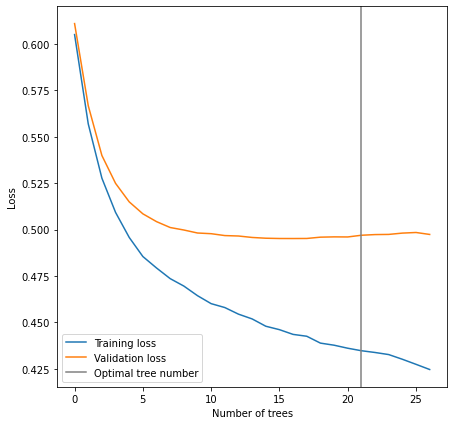

In [8]:
# visualize model performance
Classifier.visualize('logloss')

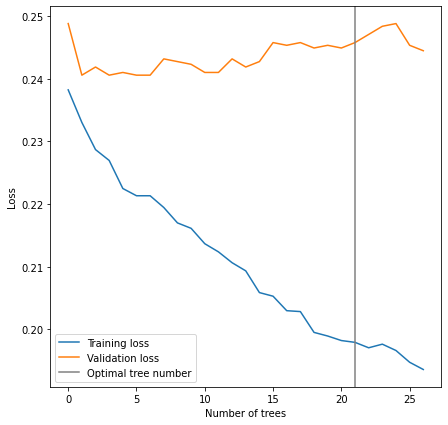

In [9]:
Classifier.visualize('error')

In [10]:
# evaluate model
Classifier.evaluate()


|-----------------------------------------|
Accuracy Score: 75.22%

Precision Score: 77.06%

Recall Score: 93.52%

F1 Score: 84.50%
|-----------------------------------------|


In [11]:
# Save Model to Disk
Classifier.save_model_to_disk("/xgboost_classifier.json")